In [1]:
import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as functional
import numpy as np
import matplotlib.pyplot as plt

In [2]:
raw_data = np.load("data.npy")

In [3]:

classes = ['frame_num', 'action', 'team_controlling_ball', 'ball_x', 'ball_y', 'num_players_team1', 'num_players_team2', 'scene', 'no_team1_players']

for i in range(11):
    classes.append('team1_player' + str(i) + 'x')
    classes.append('team1_player' + str(i) + 'y')

classes.append('no_team1_players')

for i in range(11):
    classes.append('team2_player' + str(i) + 'x')
    classes.append('team2_player' + str(i) + 'y')

In [4]:
# for i in range(500):
#     print(raw_data[i][1])


for i, value in enumerate(raw_data[-1]):
    print(f"idx {i}\t name: {classes[i]}\t\t\tvalue: {value}")

idx 0	 name: frame_num			value: 151271.0
idx 1	 name: action			value: 20
idx 2	 name: team_controlling_ball			value: 2.0
idx 3	 name: ball_x			value: 0.54453125
idx 4	 name: ball_y			value: 0.5402777777777777
idx 5	 name: num_players_team1			value: 1.0
idx 6	 name: num_players_team2			value: 8.0
idx 7	 name: scene			value: Midfield
idx 8	 name: no_team1_players			value: 1.0
idx 9	 name: team1_player0x			value: 0.94765625
idx 10	 name: team1_player0y			value: 0.5555555555555556
idx 11	 name: team1_player1x			value: 0.0
idx 12	 name: team1_player1y			value: 0.0
idx 13	 name: team1_player2x			value: 0.0
idx 14	 name: team1_player2y			value: 0.0
idx 15	 name: team1_player3x			value: 0.0
idx 16	 name: team1_player3y			value: 0.0
idx 17	 name: team1_player4x			value: 0.0
idx 18	 name: team1_player4y			value: 0.0
idx 19	 name: team1_player5x			value: 0.0
idx 20	 name: team1_player5y			value: 0.0
idx 21	 name: team1_player6x			value: 0.0
idx 22	 name: team1_player6y			value: 0.0
idx 23	 name: 

In [5]:
import os
from torch.utils.data import Dataset

class FootballData(Dataset):
    def __init__(self, path):
        raw_data = np.load(path)
        self.size = len(raw_data) - 1
        if not os.path.isdir("./barca_dataset"):
            os.mkdir('./barca_dataset/')
        for i, record in enumerate(raw_data):
            name = "./barca_dataset/record" + str(i) + ".npy"
            if not os.path.isfile(name):
                np.save(name, record)

    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        data = np.load("./barca_dataset/record" + str(idx) + ".npy")
        inputs = np.concatenate( (data[9:31], data[32:], data[3:5])).astype(np.float32) #todo we need to check those indecies
        inputs = np.array([inputs])
        inputs = torch.from_numpy(inputs)
        label = np.array([int(float(data[2])-1)])
        label = torch.from_numpy(label)
        return inputs, label

In [6]:
data = FootballData("./data.npy")

In [7]:
for i, (val, label) in enumerate(data):
    print(f"{i}: {val.size()} -- {label}")
    if i == 10:
        break

0: torch.Size([1, 46]) -- tensor([1])
1: torch.Size([1, 46]) -- tensor([1])
2: torch.Size([1, 46]) -- tensor([1])
3: torch.Size([1, 46]) -- tensor([1])
4: torch.Size([1, 46]) -- tensor([1])
5: torch.Size([1, 46]) -- tensor([1])
6: torch.Size([1, 46]) -- tensor([1])
7: torch.Size([1, 46]) -- tensor([1])
8: torch.Size([1, 46]) -- tensor([1])
9: torch.Size([1, 46]) -- tensor([1])
10: torch.Size([1, 46]) -- tensor([1])


In [8]:
class PossesionClssifier(nn.Module):
    def __init__(self):
      super(PossesionClssifier,self).__init__()
      self.stack = nn.Sequential(
        nn.Linear(46, 40),
        nn.ReLU(),
        nn.Linear(40, 30),
        nn.ReLU(),
        nn.Linear(30, 30),
        nn.ReLU(),
        nn.Linear(30, 2),
      )
    def forward(self,x):
      return self.stack(x)

model = PossesionClssifier()

In [9]:
def train_loop(model, dataloader, loss_fn, optimizer, LOG=False):
  loss_data = []
  running_loss = 0
  for batch, data in enumerate(dataloader,0):
    # inputs, label = data[0].to(device), data[1].to(device)
    inputs, label = data
    optimizer.zero_grad()
    prediction = model(inputs)
    loss = loss_fn(prediction, label)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    if batch % 2000 == 1999:
      print(f"loss: {running_loss/(2000)}")
      loss_data.append(running_loss/(2000))
      running_loss = 0
    if batch == 50_000:
       return loss_data

In [10]:
learning_rate = 0.0001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

data = train_loop(model=model,
           dataloader=data,
           loss_fn=loss_fn,
           optimizer=optimizer,
           LOG=False)
plt.plot(data)
plt.shw()

loss: 0.6485656198859214
loss: 0.5798954392969609
loss: 0.5519208643436432
loss: 0.5068117934316396
loss: 0.6431160036623478
loss: 0.4366263877153397
loss: 0.45855068726837633
loss: 0.4407566163986921
loss: 0.39175926353037355
loss: 0.4343952356427908
loss: 0.42041395071148874
loss: 0.3602529398202896
loss: 0.3235112889930606
loss: 0.3439471556097269
loss: 0.3395471464172006
loss: 0.7164531999379397
loss: 0.5854716252461076
loss: 0.5663307598754763
loss: 0.667516426242888
loss: 0.6214796277955175
loss: 0.6047835577875376
loss: 0.7532578379660845
loss: 0.6636421642452478
loss: 0.6146758266687393
loss: 0.7738805079609156


AttributeError: module 'matplotlib.pyplot' has no attribute 'shw'

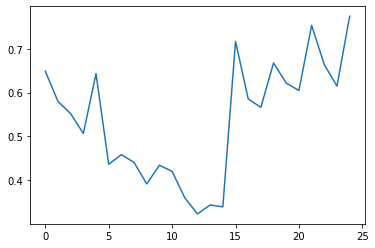

In [12]:
plt.plot(data)